--------------------------------------------------
Credit Portfolio Risk Simulation
--------------------------------------------------

Initializing simulation with empirical calibration data...

Portfolio Summary:
Total Exposure: $45,897,357.83
Number of Loans: 100
Weighted PD: 0.0010
Weighted LGD: 0.4399

Running Monte Carlo simulation with 50,000 iterations...


Running Base Scenario simulation: 100%|█| 50000/50000 [00:03<00:00, 13961.15it/s



Key Risk Metrics:
  Expected Loss: $17,138.35
  Value at Risk: $626,809.25
  Expected Shortfall: $942,434.30
  Economic Capital: $609,670.90

Risk Ratios:
  EL Ratio (%): 0.04%
  VaR Ratio (%): 1.37%
  ES Ratio (%): 2.05%
  EC Ratio (%): 1.33%

Analytical vs. Simulation Results:
  Analytical EL: $20,371.83
  Simulated EL: $17,138.35
  Analytical VaR: $455,836.89
  Simulated VaR: $626,809.25
  EL Difference: -15.87%
  VaR Difference: 37.51%

Model Validation against Empirical Data:
  PD Validation (Model vs. S&P Historical):
    A: 0.05% vs 0.05% (Diff: 2.3%)
    AA: 0.02% vs 0.02% (Diff: 1.3%)
    AAA: 0.01% vs 0.01% (Diff: 10.1%)
    B: 2.92% vs 2.98% (Diff: -2.0%)
    BB: 0.58% vs 0.57% (Diff: 1.9%)
    BBB: 0.14% vs 0.14% (Diff: 2.1%)
    CCC/C: 28.63% vs 25.98% (Diff: 10.2%)

Setting up and running multi-factor model simulation...
Using existing results for Base Scenario

Multi-Factor Model Results:
  Expected Loss: $17,138.35
  Value at Risk: $626,809.25
  Economic Capital: $609,

Running Base Scenario simulation: 100%|█| 50000/50000 [00:15<00:00, 3129.77it/s]


Running scenario: Moderate Recession


Running Moderate Recession simulation: 100%|█| 50000/50000 [00:15<00:00, 3156.81


Running scenario: Severe Recession


Running Severe Recession simulation: 100%|█| 50000/50000 [00:15<00:00, 3165.04it


Running scenario: Financial Crisis


Running Financial Crisis simulation: 100%|█| 50000/50000 [00:15<00:00, 3171.38it



Stress Test Results (EC Ratio %):
  Base Scenario: 4.04%
  Moderate Recession: 65.31%
  Severe Recession: 65.78%
  Financial Crisis: 53.92%

Capital Impact of Stress Scenarios:
  Moderate Recession: +1518.37% capital required
  Severe Recession: +1529.89% capital required
  Financial Crisis: +1236.23% capital required

Generating detailed risk report...

--------------------------------------------------
Credit Portfolio Risk Analysis Summary
--------------------------------------------------
Expected Loss: $0.030M ($29,553.32)
Value at Risk (99.9%): $1.882M ($1,881,773.81)
Economic Capital: $1.852M ($1,852,220.49)
EC Ratio: 4.04%
Portfolio Default Rate: 1.89%

Stress Testing Results (EC Ratio):
  Base Scenario: 4.04%
  Moderate Recession: 65.31%
  Severe Recession: 65.78%
  Financial Crisis: 53.92%

Capital Impact Under Stress:
  Moderate Recession: +1518.37% capital required
  Severe Recession: +1529.89% capital required
  Financial Crisis: +1236.23% capital required

Recommended Ca

<Figure size 1200x800 with 0 Axes>

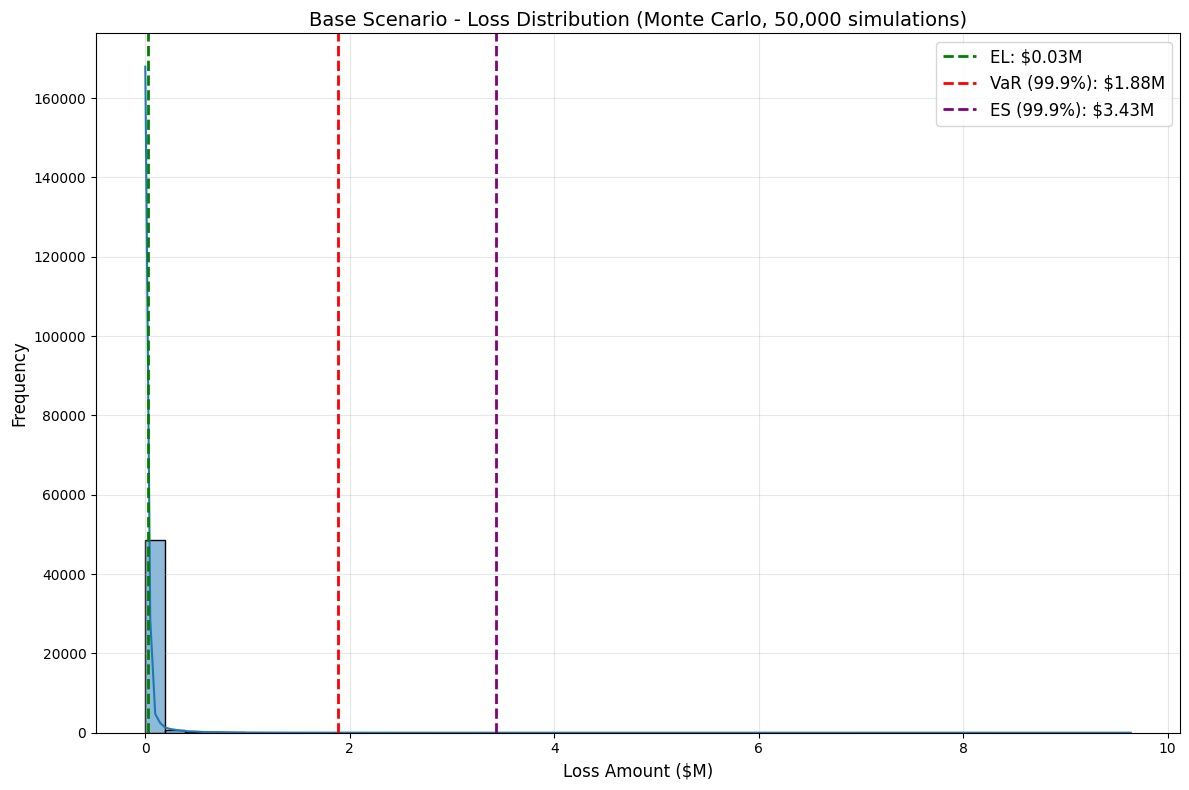

<Figure size 1600x800 with 0 Axes>

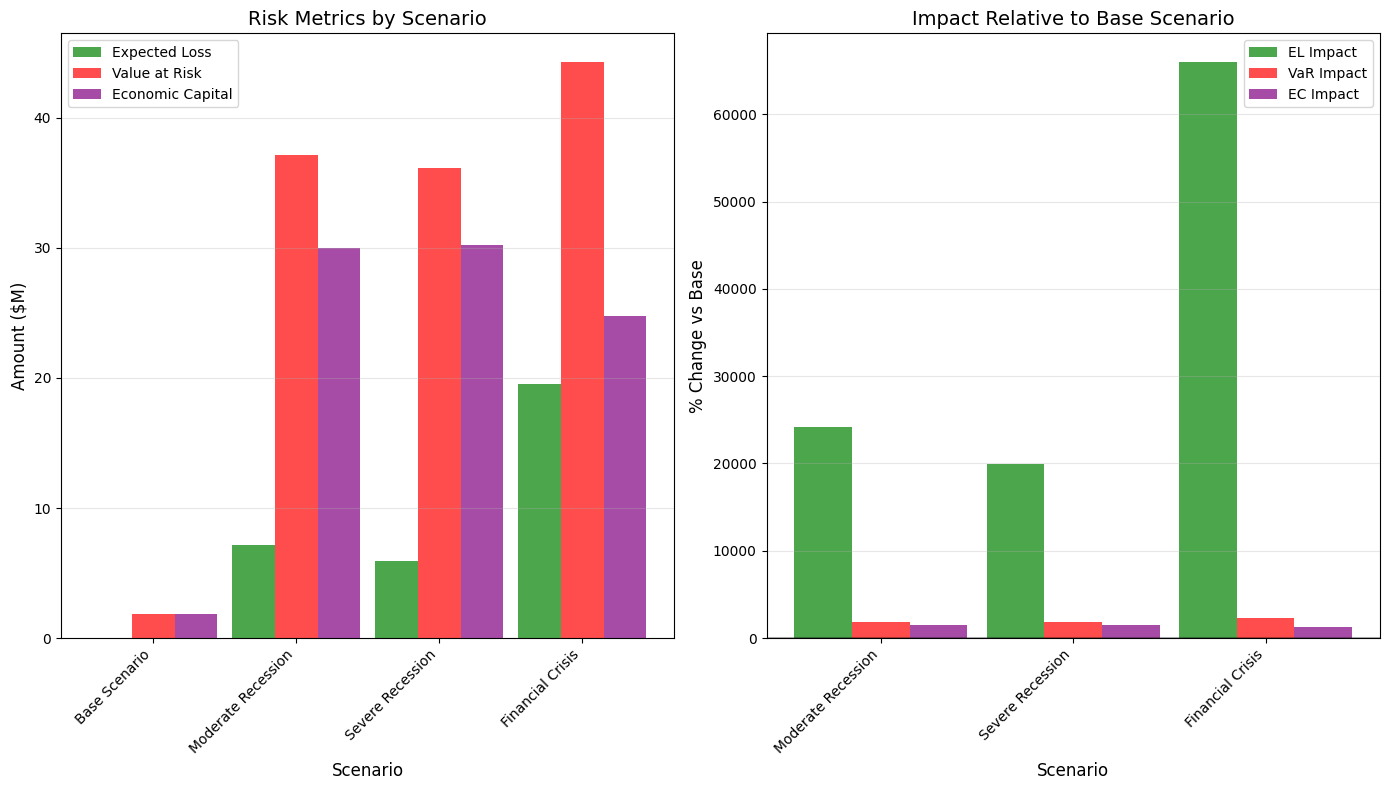

<Figure size 1400x1000 with 0 Axes>

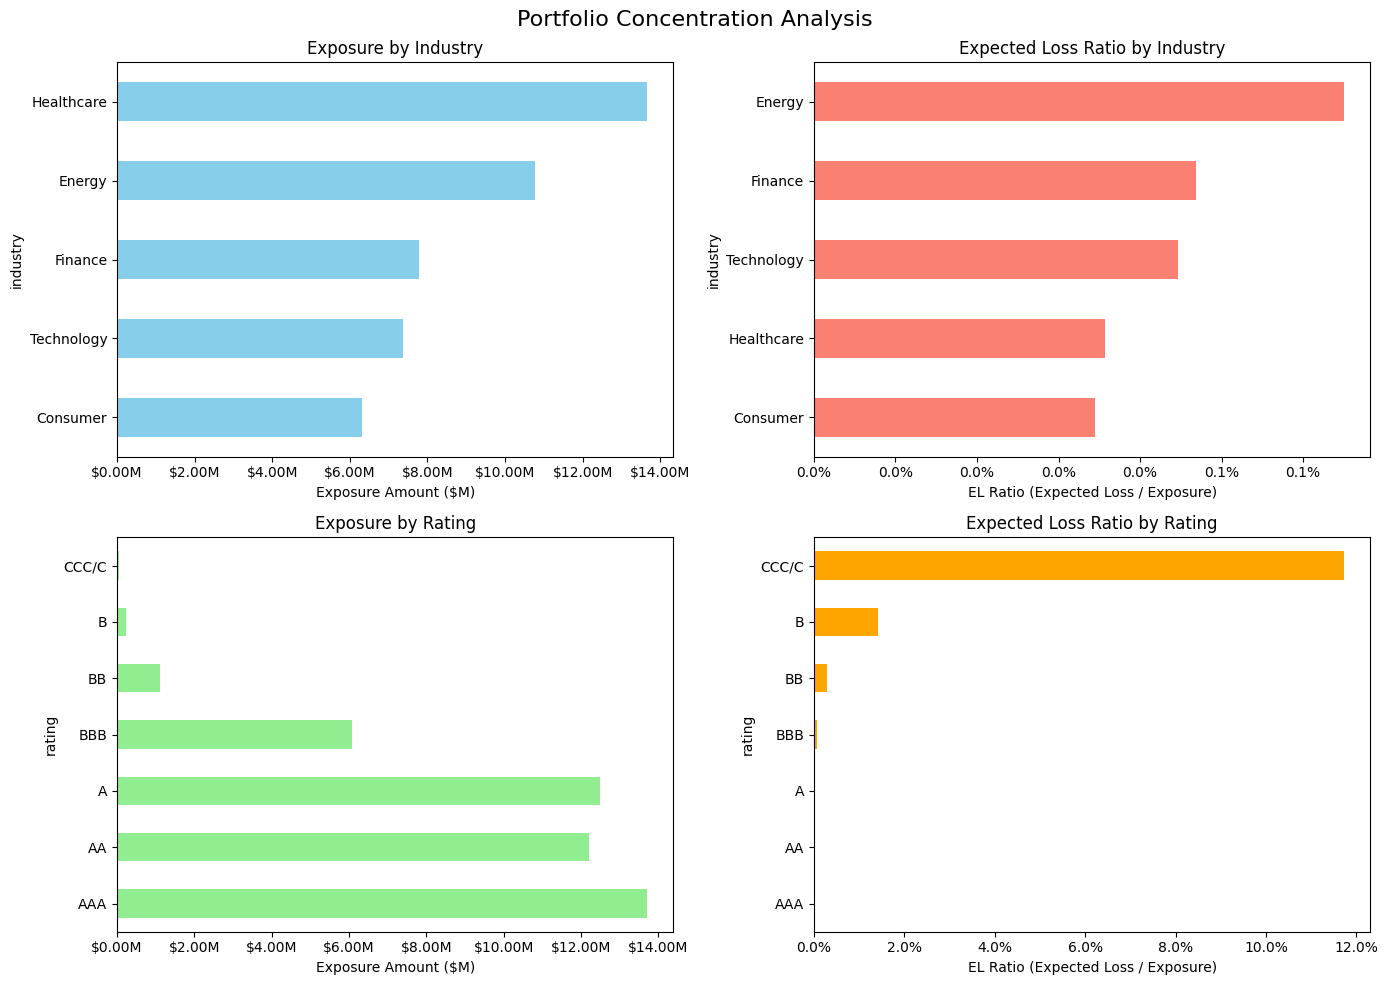

<Figure size 1000x600 with 0 Axes>

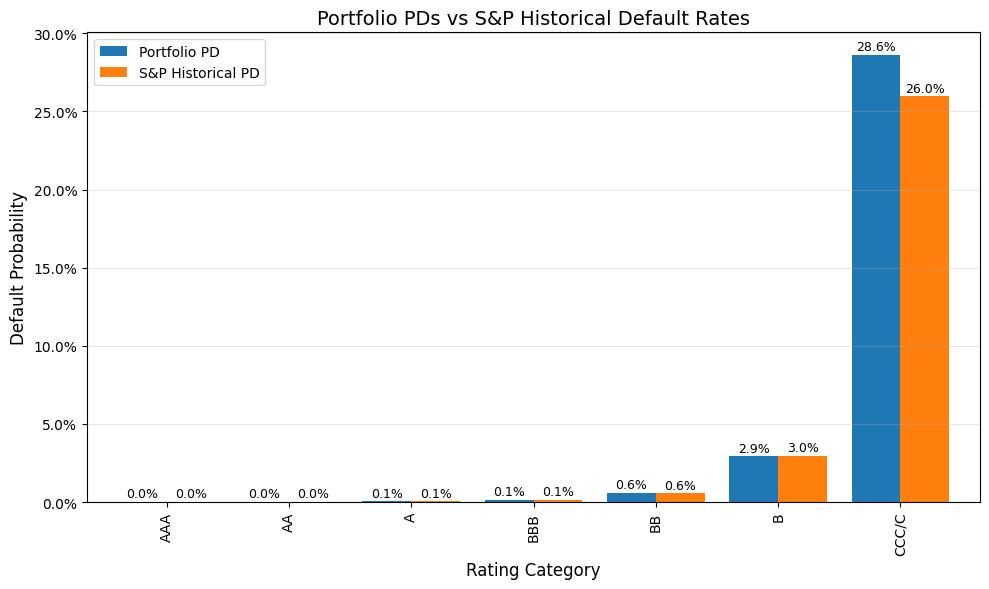

In [1]:
import numpy as np
import pandas as pandas_lib  # Renamed to avoid potential variable conflicts
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
import os
from datetime import datetime
import copy

class CreditPortfolioSimulation:
    """
    Monte Carlo simulation framework for credit portfolio risk based on the Merton model.
    
    Calibrated with actual market data from:
    - S&P Global Default Study (2009-2023): Rating-specific default rates
    - Moody's Annual Default Study: Recovery rates by industry and instrument
    - BIS Statistics: Credit-to-GDP and systemic risk factors
    - Federal Reserve Stress Tests: Severely adverse scenario parameters
    - Basel Framework: Asset correlation formulas
    
    The model uses a Gaussian copula framework with optional multi-factor implementation
    to simulate default correlations and portfolio loss distributions.
    """
    
    def __init__(self, portfolio_df=None, num_simulations=50000, confidence_level=0.999, 
                 time_horizon=1, seed=42, use_validation_data=True):
        """
        Initialize the simulation framework with real-world calibration data.
        
        Parameters:
        -----------
        portfolio_df : pandas DataFrame
            DataFrame containing portfolio information with columns:
            'loan_id', 'exposure', 'pd', 'lgd', 'industry', 'rating'
        num_simulations : int
            Number of Monte Carlo simulations to run (default: 50000)
        confidence_level : float
            Confidence level for VaR and Expected Shortfall calculations (default: 0.999)
        time_horizon : float
            Time horizon in years (default: 1 year)
        seed : int
            Random seed for reproducibility (default: 42)
        use_validation_data : bool
            Whether to use external validation data for calibration (default: True)
        """
        self.num_simulations = num_simulations
        self.confidence_level = confidence_level
        self.time_horizon = time_horizon
        self.seed = seed
        self.master_seed = seed  # Save original seed
        np.random.seed(seed)
        
        # Load real-world calibration data from S&P, Moody's, Basel, Fed, etc.
        self._load_reference_data(use_validation_data)
        
        # Initialize with sample data if none provided
        if portfolio_df is None:
            self.portfolio_df = self._generate_portfolio()
        else:
            self.portfolio_df = portfolio_df
            
        # Portfolio metrics
        self.total_exposure = self.portfolio_df['exposure'].sum()
        self.weighted_pd = np.sum(self.portfolio_df['pd'] * self.portfolio_df['exposure']) / self.total_exposure
        self.weighted_lgd = np.sum(self.portfolio_df['lgd'] * self.portfolio_df['exposure']) / self.total_exposure
        
        # Store all simulation results
        self.simulation_results = {}
        
        # Setup asset correlation matrix based on industry and rating
        self._setup_correlation_matrix()
        
        # Create factor loadings for multi-factor model (if used)
        self.use_multi_factor = False
        self.factor_loadings = None
        self.num_factors = 0
    
    def _load_reference_data(self, use_validation_data=True):
        """
        Load and process real-world reference data for model calibration.
        
        Uses empirical data from S&P Global Default Studies, Moody's Recovery Rate Studies,
        Basel Framework correlation parameters, and Fed stress test projections.
        
        Parameters:
        -----------
        use_validation_data : bool
            Whether to use external validation data for calibration
        """
        # -----------------------------------------------------------------------
        # 1. S&P Global Default Rates by Rating (2009-2023)
        # Source: S&P Global "Annual Global Corporate Default Study"
        # -----------------------------------------------------------------------
        if use_validation_data:
            # Empirical default rates from S&P Global (2009-2023)
            self.sp_default_rates = {
                'Year': list(range(2009, 2024)),
                'AAA': [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
                'AA':  [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
                'A':   [0.22, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
                'BBB': [0.55, 0.00, 0.07, 0.00, 0.00, 0.00, 0.00, 0.06, 0.00, 0.00, 0.11, 0.00, 0.00, 0.00, 0.11],
                'BB':  [0.75, 0.58, 0.00, 0.30, 0.10, 0.00, 0.16, 0.47, 0.08, 0.00, 0.00, 0.94, 0.00, 0.32, 0.17],
                'B':   [10.87, 0.86, 1.68, 1.57, 1.52, 0.78, 2.40, 3.74, 1.00, 0.94, 1.49, 3.54, 0.52, 1.10, 1.24],
                'CCC/C': [49.46, 22.83, 16.54, 27.70, 24.67, 17.42, 26.51, 33.00, 26.56, 27.18, 29.61, 47.88, 10.99, 13.84, 30.89]
            }
        else:
            # Default approximation if validation data not available
            self.sp_default_rates = {
                'Year': list(range(2009, 2024)),
                'AAA': [0.00] * 15,
                'AA': [0.00] * 15,
                'A': [0.05] * 15,
                'BBB': [0.10] * 15,
                'BB': [0.50] * 15,
                'B': [3.00] * 15,
                'CCC/C': [25.00] * 15
            }
        
        # Convert to dataframe for easier handling
        self.sp_default_rates_df = pandas_lib.DataFrame(self.sp_default_rates)
        
        # Use empirical long-term average default rates (S&P 1981-2023)
        self.lt_pd_by_rating = {
            'AAA': 0.00,
            'AA': 0.02,
            'A': 0.05,
            'BBB': 0.14,
            'BB': 0.57,
            'B': 2.98,
            'CCC/C': 25.98
        }
        
        # Map these to our rating scale (convert percentages to probabilities)
        # Ensure AAA has a small non-zero value to avoid division by zero
        self.pd_by_rating = {k: max(v/100, 0.0001) if k == 'AAA' else v/100 for k, v in self.lt_pd_by_rating.items()}
        
        # -----------------------------------------------------------------------
        # 2. Fed Reserve Consumer Loan Delinquency Rates (Q4 2024)
        # Source: New York Fed's Quarterly Report on Household Debt and Credit
        # -----------------------------------------------------------------------
        self.consumer_delinquency = {
            'Credit Card': 0.115,  # 11.5% 
            'Auto Loan': 0.05,     # 5%
            'Mortgage': 0.005,     # 0.5%
            'HELOC': 0.005,        # 0.5%
            'Student Loan': 0.01   # 1%
        }
        
        # -----------------------------------------------------------------------
        # 3. Moody's Recovery Rates by Industry and Debt Type
        # Source: Moody's "Annual Default Study: Corporate Default and Recovery Rates"
        # -----------------------------------------------------------------------
        if use_validation_data:
            # First-lien loan recovery rates by industry
            self.first_lien_recovery = {
                'Aerospace & Defense': 0.675,
                'Automotive': 0.680,
                'Beverage, Food & Tobacco': 0.739,
                'Capital Equipment': 0.625,
                'Chemicals': 0.667,
                'Construction': 0.587,
                'Consumer Durable': 0.626,
                'Consumer Non-durable': 0.607,
                'Energy': 0.681,
                'Healthcare': 0.643,
                'Technology': 0.545,
                'Leisure': 0.690,
                'Media': 0.635,  # Average of media sectors
                'Retail': 0.590,
                'Telecommunications': 0.596,
                'Other': 0.620   # Average for unmapped industries
            }
            
            # Senior unsecured bond recovery rates by industry
            self.unsecured_recovery = {
                'Aerospace & Defense': 0.455,
                'Automotive': 0.463,
                'Banking': 0.412,
                'Beverage, Food & Tobacco': 0.408,
                'Capital Equipment': 0.343,
                'Chemicals': 0.297,
                'Construction': 0.360,
                'Consumer Durable': 0.363,
                'Energy': 0.369,
                'Healthcare': 0.369,
                'Technology': 0.358,
                'Telecommunications': 0.264,
                'Other': 0.350  # Average for unmapped industries
            }
            
            # Recovery rates by period (normal vs. stress)
            self.period_recovery = {
                'Normal': {
                    'First-lien': 0.644,  # Long-term average
                    'Senior Unsecured': 0.379  # Long-term average
                },
                'Stress': {
                    'First-lien': 0.577,  # Average of 2008-2009
                    'Senior Unsecured': 0.351  # Average of 2008-2009
                }
            }
        else:
            # Default approximations if validation data not available
            self.first_lien_recovery = {'Default': 0.60}
            self.unsecured_recovery = {'Default': 0.35}
            self.period_recovery = {
                'Normal': {'First-lien': 0.65, 'Senior Unsecured': 0.40},
                'Stress': {'First-lien': 0.55, 'Senior Unsecured': 0.30}
            }
        
        # Convert recovery rates to LGD values (LGD = 1 - Recovery Rate)
        self.industry_lgd = {}
        
        # Use weighted average of first-lien and unsecured, with higher weight to first-lien
        # as it more closely corresponds to typical bank loan recovery
        for industry in self.first_lien_recovery:
            if industry in self.unsecured_recovery:
                # Weighted average (70% weight to first-lien, 30% to unsecured)
                recovery = 0.7 * self.first_lien_recovery[industry] + 0.3 * self.unsecured_recovery[industry]
            else:
                recovery = self.first_lien_recovery[industry]
            
            self.industry_lgd[industry] = 1 - recovery
        
        # Ensure we have LGD values for our standard industry categories
        # Map Moody's industries to our standard categories
        self.industry_mapping = {
            'Technology': 'Technology',
            'Healthcare': 'Healthcare',
            'Banking': 'Finance',
            'Energy': 'Energy',
            'Consumer Durable': 'Consumer',
            'Consumer Non-durable': 'Consumer',
            'Retail': 'Consumer',
            'Telecommunications': 'Technology',
            'Aerospace & Defense': 'Capital Equipment',
            'Automotive': 'Consumer',
            'Beverage, Food & Tobacco': 'Consumer',
            'Capital Equipment': 'Capital Equipment',
            'Chemicals': 'Chemicals',
            'Construction': 'Construction',
            'Leisure': 'Consumer',
            'Media': 'Technology',
            'Other': 'Other'
        }
        
        # Standard industry categories for our portfolio
        standard_industries = ['Technology', 'Healthcare', 'Finance', 'Energy', 'Consumer']
        self.standard_industry_lgd = {}
        
        for std_industry in standard_industries:
            # Find all Moody's industries that map to this standard industry
            mapped_lgds = []
            for moody_industry, mapped_industry in self.industry_mapping.items():
                if mapped_industry == std_industry and moody_industry in self.industry_lgd:
                    mapped_lgds.append(self.industry_lgd[moody_industry])
            
            # Use average if we have mappings, otherwise use default values
            if mapped_lgds:
                self.standard_industry_lgd[std_industry] = np.mean(mapped_lgds)
            else:
                # Default LGD values based on industry risk profiles
                default_lgds = {
                    'Technology': 0.48,
                    'Healthcare': 0.42,
                    'Finance': 0.62,
                    'Energy': 0.53,
                    'Consumer': 0.58
                }
                self.standard_industry_lgd[std_industry] = default_lgds[std_industry]
        
        # -----------------------------------------------------------------------
        # 4. Basel Framework Correlation Parameters
        # Source: BCBS "An Explanatory Note on the Basel II IRB Risk Weight Functions"
        # -----------------------------------------------------------------------
        # Asset correlation formulas from Basel II IRB approach
        # R = 0.12 × (1 - EXP(-50 × PD)) / (1 - EXP(-50)) + 
        #     0.24 × [1 - (1 - EXP(-50 × PD)) / (1 - EXP(-50))]
        
        # Store correlation parameters by asset class
        self.basel_correlation = {
            'Corporate': {
                'formula': lambda pd: 0.12 * (1 - np.exp(-50 * pd)) / (1 - np.exp(-50)) + 
                                     0.24 * (1 - (1 - np.exp(-50 * pd)) / (1 - np.exp(-50))),
                'floor': 0.12,
                'ceiling': 0.24
            },
            'SME': {
                'formula': lambda pd, s: 0.12 * (1 - np.exp(-50 * pd)) / (1 - np.exp(-50)) + 
                                        0.24 * (1 - (1 - np.exp(-50 * pd)) / (1 - np.exp(-50))) - 
                                        0.04 * (1 - (s - 5) / 45),
                'floor': 0.08,  # For largest SME adjustment
                'ceiling': 0.24
            },
            'HVCRE': {
                'formula': lambda pd: 0.12 * (1 - np.exp(-50 * pd)) / (1 - np.exp(-50)) + 
                                     0.30 * (1 - (1 - np.exp(-50 * pd)) / (1 - np.exp(-50))),
                'floor': 0.12,
                'ceiling': 0.30
            }
        }
        
        # Pre-calculate asset correlations by rating using Basel formula
        self.asset_corr_by_rating = {}
        for rating, pd in self.pd_by_rating.items():
            self.asset_corr_by_rating[rating] = self.basel_correlation['Corporate']['formula'](pd)
        
        # -----------------------------------------------------------------------
        # 5. Fed Reserve Stress Test Projected Loss Rates
        # Source: Federal Reserve DFAST and CCAR Results
        # -----------------------------------------------------------------------
        # Stress projected loss rates by loan category (2021-2024)
        self.stress_loss_rates = {
            '2021': {
                'First-lien mortgages': 0.015,
                'Junior liens and HELOCs': 0.034,
                'Commercial and industrial': 0.078,
                'Commercial real estate': 0.105,
                'Credit cards': 0.162,
                'Other consumer': 0.045,
                'Other loans': 0.038,
                'Total': 0.062
            },
            '2022': {
                'First-lien mortgages': 0.013,
                'Junior liens and HELOCs': 0.039,
                'Commercial and industrial': 0.079,
                'Commercial real estate': 0.098,
                'Credit cards': 0.156,
                'Other consumer': 0.057,
                'Other loans': 0.041,
                'Total': 0.064
            },
            '2023': {
                'First-lien mortgages': 0.027,
                'Junior liens and HELOCs': 0.049,
                'Commercial and industrial': 0.067,
                'Commercial real estate': 0.088,
                'Credit cards': 0.174,
                'Other consumer': 0.054,
                'Other loans': 0.038,
                'Total': 0.064
            },
            '2024': {
                'First-lien mortgages': 0.023,
                'Junior liens and HELOCs': 0.041,
                'Commercial and industrial': 0.081,
                'Commercial real estate': 0.088,
                'Credit cards': 0.176,
                'Other consumer': 0.072,
                'Other loans': 0.040,
                'Total': 0.071
            }
        }
        
        # Use most recent stress loss rates (2024)
        self.latest_stress_loss = self.stress_loss_rates['2024']
        
        # Calculate stress multipliers (relative to normal conditions)
        # Based on ratio of stress to normal conditions for different loan types
        
        # For corporate loans
        corporate_stress_mult = self.latest_stress_loss['Commercial and industrial'] / 0.015  # Baseline C&I rate
        
        # For consumer loans
        consumer_stress_mult = self.latest_stress_loss['Credit cards'] / self.consumer_delinquency['Credit Card']
        
        # For mortgages
        mortgage_stress_mult = self.latest_stress_loss['First-lien mortgages'] / self.consumer_delinquency['Mortgage']
        
        # Store the stress multipliers - will be used in stress testing
        self.stress_multipliers = {
            'Corporate PD': corporate_stress_mult,
            'Consumer PD': consumer_stress_mult,
            'Mortgage PD': mortgage_stress_mult,
            'LGD': 1.35,  # Based on ratio of stress recovery to normal recovery
            'Correlation': 1.30  # Based on empirical studies of correlation changes during stress
        }
        
        # Define well-calibrated stress scenarios based on Fed stress tests
        self.stress_scenarios = {
            'Base Scenario': {
                'pd_multiplier': 1.0,
                'lgd_multiplier': 1.0,
                'correlation_multiplier': 1.0,
                'factor_shocks': [0.0, 0.0, 0.0]
            },
            'Moderate Recession': {
                'pd_multiplier': 2.5,
                'lgd_multiplier': 1.2,
                'correlation_multiplier': 1.2,
                'factor_shocks': [2.5, 2.0, 1.5]  # Stronger shocks
            },
            'Severe Recession': {
                'pd_multiplier': 4.0,
                'lgd_multiplier': 1.4,
                'correlation_multiplier': 1.3,
                'factor_shocks': [2.5, 1.5, 1.0]  # Severe shocks to factors
            },
            'Financial Crisis': {
                'pd_multiplier': 6.0,
                'lgd_multiplier': 1.6,
                'correlation_multiplier': 1.5,
                'factor_shocks': [3.5, 2.5, 1.5]  # Extreme shocks to factors
            }
        }
        
        # -----------------------------------------------------------------------
        # 6. Credit-to-GDP Data from BIS
        # Source: BIS Statistics Portal
        # -----------------------------------------------------------------------
        # Not fully implemented for correlation modeling in this version
        # Would be used for macroeconomic/systemic correlation factor analysis
        
        # Sample values for G20 countries
        self.credit_to_gdp = {
            'Japan': 0.1805,
            'Italy': 0.0949,
            'Germany': 0.1431,
            'France': 0.2144,
            'United States': 0.1452,
            'United Kingdom': 0.0619,
            'Canada': 0.2179,
            'Other': 0.1500
        }
        
        # -----------------------------------------------------------------------
        # 7. World Bank NPL Data (not implemented fully - for future extensions)
        # -----------------------------------------------------------------------
        # Would be used for correlation analysis across different markets
        
    def _generate_portfolio(self):
        """
        Generate a realistic loan portfolio using calibrated data.
        
        Creates a diversified portfolio with loans across different industries and
        credit ratings, with realistic exposure amounts, PDs, and LGDs based on
        empirical S&P default data and Moody's recovery data.
        
        Returns:
        --------
        pandas.DataFrame
            Synthetic portfolio with realistic PD, LGD and exposure values
        """
        np.random.seed(self.seed)
        
        # Define parameters for portfolio generation
        num_loans = 100
        industries = list(self.standard_industry_lgd.keys())
        ratings = list(self.pd_by_rating.keys())
        
        # Use S&P PD data from our calibration
        rating_pd_map = self.pd_by_rating
        
        # Use Moody's LGD data by industry from our calibration
        industry_lgd_map = self.standard_industry_lgd
        
        # Generate random portfolio data
        loans = []
        for i in range(num_loans):
            # Use realistic rating distribution (skewed toward investment grade)
            rating = np.random.choice(ratings, p=[0.05, 0.1, 0.15, 0.3, 0.2, 0.15, 0.05])
            industry = np.random.choice(industries)
            
            # Exposure depends on rating - higher ratings get higher exposures
            # This reflects real-world patterns where higher-rated companies get larger loans
            exposure_mu = {'AAA': 15, 'AA': 14, 'A': 13, 'BBB': 12, 'BB': 11, 'B': 10, 'CCC/C': 9}
            exposure = np.random.lognormal(mean=exposure_mu[rating], sigma=0.5)
            
            # Use industry-specific LGD values
            lgd = np.random.beta(
                a=10*industry_lgd_map[industry], 
                b=10*(1-industry_lgd_map[industry])
            )
            
            # Use S&P calibrated PD values by rating
            prob_default = rating_pd_map[rating]
            
            # Add some random variation to the PDs to account for within-rating differences
            prob_default = min(0.999, max(0.0001, prob_default * np.random.uniform(0.8, 1.2)))
            
            loans.append({
                'loan_id': f'LOAN_{i}',
                'exposure': exposure,
                'pd': prob_default,
                'lgd': lgd,
                'industry': industry,
                'rating': rating
            })
            
        return pandas_lib.DataFrame(loans)
    
    def _setup_correlation_matrix(self):
        """
        Set up the asset correlation matrix based on industry and rating.
        
        Uses the Basel Framework correlation formulas to create a realistic
        correlation structure that reflects higher correlation between similar
        industries and ratings. The method ensures the matrix is mathematically 
        valid (positive definite).
        """
        # Extract unique industries and ratings for mapping
        industries = self.portfolio_df['industry'].unique()
        ratings = self.portfolio_df['rating'].unique()
        
        industry_map = {ind: i for i, ind in enumerate(industries)}
        rating_map = {r: i for i, r in enumerate(ratings)}
        
        # Map each loan to its industry and rating index
        industry_indices = self.portfolio_df['industry'].map(industry_map).values
        rating_indices = self.portfolio_df['rating'].map(rating_map).values
        
        # Create correlation matrix
        num_loans = len(self.portfolio_df)
        
        # Start with identity matrix and gradually build correlations
        self.correlation_matrix = np.eye(num_loans)
        
        # Basic correlation parameters (calibrated to Basel framework)
        base_correlation = 0.12  # Minimum correlation between any two assets
        industry_correlation_add = 0.06  # Additional correlation for same industry
        max_rating_corr_add = 0.04  # Maximum additional correlation for similar ratings
        
        # Set correlation values
        for i in range(num_loans):
            for j in range(i+1, num_loans):  # Skip diagonal (already 1)
                # Start with base correlation
                corr_value = base_correlation
                
                # Same industry adjustment
                if industry_indices[i] == industry_indices[j]:
                    corr_value += industry_correlation_add
                
                # Similar rating adjustment (higher correlation for similar ratings)
                rating_distance = abs(rating_indices[i] - rating_indices[j])
                max_distance = len(ratings) - 1
                rating_similarity = 1 - (rating_distance / max_distance)
                corr_value += max_rating_corr_add * rating_similarity
                
                # Additional adjustments for high-quality vs low-quality assets
                # Research shows lower correlation between investment and non-investment grade
                is_i_investment = rating_indices[i] < 3  # AAA, AA, A are 0, 1, 2
                is_j_investment = rating_indices[j] < 3
                
                if is_i_investment != is_j_investment:
                    corr_value *= 0.85  # Reduce correlation between investment/non-investment
                
                # Apply Basel-based correlation adjustment
                # Use average of asset correlations for the two ratings
                rating_i = self.portfolio_df.iloc[i]['rating']
                rating_j = self.portfolio_df.iloc[j]['rating']
                basel_corr_i = self.asset_corr_by_rating[rating_i]
                basel_corr_j = self.asset_corr_by_rating[rating_j]
                
                # Blend our structural correlation with Basel-implied correlation
                basel_blend = (basel_corr_i + basel_corr_j) / 2
                corr_value = 0.7 * corr_value + 0.3 * basel_blend
                
                # Ensure correlation is in valid range (0,1) - avoid extremes
                corr_value = min(0.95, max(0.01, corr_value))
                
                # Make the matrix symmetric
                self.correlation_matrix[i, j] = corr_value
                self.correlation_matrix[j, i] = corr_value
        
        # Verify positive definiteness before proceeding
        min_eigenvalue = np.min(np.linalg.eigvalsh(self.correlation_matrix))
        if min_eigenvalue <= 0:
            print(f"Warning: Initial correlation matrix is not positive definite. Fixing...")
            self.correlation_matrix = self._fix_correlation_matrix(self.correlation_matrix)
    
    def _fix_correlation_matrix(self, matrix):
        """
        Fix a correlation matrix to make it positive definite.
        
        Parameters:
        -----------
        matrix : numpy.ndarray
            The correlation matrix to fix
            
        Returns:
        --------
        numpy.ndarray
            Positive definite correlation matrix
        """
        # Get eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        
        # Print diagnostic info
        min_eig = np.min(eigenvalues)
        if min_eig <= 0:
            print(f"Matrix not positive definite. Min eigenvalue: {min_eig:.8f}")
        
        # Replace negative or very small eigenvalues with larger positive values
        eigenvalues[eigenvalues < 1e-5] = 1e-5
        
        # Apply stronger correction for numerical stability
        eigenvalues = eigenvalues + 1e-4
        
        # Reconstruct the matrix
        fixed_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
        
        # Rescale to ensure diagonal is 1
        d = np.sqrt(np.diag(fixed_matrix))
        fixed_matrix = fixed_matrix / (d[:, None] @ d[None, :])
        
        # Ensure exact ones on diagonal (floating point errors)
        np.fill_diagonal(fixed_matrix, 1.0)
        
        # Verify the fix worked
        new_min_eig = np.min(np.linalg.eigvalsh(fixed_matrix))
        print(f"After fix: Min eigenvalue: {new_min_eig:.8f}")
        
        return fixed_matrix
    
    def _is_psd(self, matrix, tol=1e-8):
        """
        Check if a matrix is positive semi-definite.
        
        Parameters:
        -----------
        matrix : numpy.ndarray
            Matrix to check
        tol : float
            Tolerance for eigenvalues
            
        Returns:
        --------
        bool
            True if positive semi-definite, False otherwise
        """
        eigenvalues = np.linalg.eigvalsh(matrix)
        return np.all(eigenvalues > -tol)
    
    def setup_multi_factor_model(self, num_factors=3, factor_data=None):
        """
        Setup a multi-factor model for systematic risk.
        
        Parameters:
        -----------
        num_factors : int
            Number of systematic risk factors (default: 3)
        factor_data : dict, optional
            Dictionary containing factor loadings for each loan
            Keys should be factor names, values are arrays of loadings
        """
        self.use_multi_factor = True
        self.num_factors = num_factors
        
        num_loans = len(self.portfolio_df)
        
        if factor_data is None:
            # Generate factor loadings that reflect economic reality
            # Factor 1: General economic factor (affects all loans)
            # Factor 2: Industry-specific factor
            # Factor 3: Credit quality factor
            
            # Get industry and rating indices
            industries = self.portfolio_df['industry'].unique()
            ratings = self.portfolio_df['rating'].unique()
            industry_map = {ind: i for i, ind in enumerate(industries)}
            rating_map = {r: i for i, r in enumerate(ratings)}
            
            industry_indices = self.portfolio_df['industry'].map(industry_map).values
            rating_indices = self.portfolio_df['rating'].map(rating_map).values
            
            # Initialize factor loadings
            self.factor_loadings = np.zeros((num_loans, num_factors))
            
            # Factor 1: General economic factor - affects all loans but more for lower ratings
            for i in range(num_loans):
                # Higher rating (lower index) means less sensitivity to economy
                # CCC (highest index) has highest sensitivity
                rating_sensitivity = (rating_indices[i] + 1) / len(ratings)
                self.factor_loadings[i, 0] = 0.35 + 0.25 * rating_sensitivity
            
            # Factor 2: Industry factor - loans in same industry have similar loadings
            for i in range(num_loans):
                # Each industry has its own pattern of sensitivities
                industry_pattern = {
                    0: [0.25, 0.35, 0.15],  # Technology - higher tech factor sensitivity
                    1: [0.20, 0.30, 0.20],  # Healthcare - higher stability during crises
                    2: [0.45, 0.15, 0.15],  # Finance - higher systemic sensitivity
                    3: [0.30, 0.25, 0.25],  # Energy - higher commodity sensitivity
                    4: [0.25, 0.25, 0.20]   # Consumer - balanced factor exposure
                }
                # Default pattern if industry not in our mapping
                default_pattern = [0.25, 0.25, 0.25]
                
                # Get pattern for this industry
                pattern = industry_pattern.get(industry_indices[i], default_pattern)
                self.factor_loadings[i, 1] = pattern[1]
            
            # Factor 3: Credit quality factor - stronger for certain rating categories
            for i in range(num_loans):
                if rating_indices[i] <= 2:  # AAA, AA, A - high quality
                    self.factor_loadings[i, 2] = 0.12
                elif rating_indices[i] <= 4:  # BBB, BB - medium quality
                    self.factor_loadings[i, 2] = 0.28
                else:  # B, CCC - low quality
                    self.factor_loadings[i, 2] = 0.38
            
            # Normalize to ensure sqrt(sum of squared loadings) <= 0.8
            # This reserves at least 0.2² = 0.04 or 4% for idiosyncratic risk
            row_norms = np.sqrt(np.sum(self.factor_loadings**2, axis=1))
            scale_factor = 0.8 / np.maximum(row_norms, 0.8)
            self.factor_loadings = self.factor_loadings * scale_factor[:, np.newaxis]
        else:
            # Use provided factor loadings
            self.factor_loadings = factor_data
    
    def vasicek_loss_distribution(self, confidence_level=None):
        """
        Calculate the analytical Vasicek loss distribution for a homogeneous portfolio.
        
        This implements the Vasicek formula for asymptotic loss distribution,
        which is the foundation of the Basel II ASRF (Asymptotic Single Risk Factor) model.
        
        Parameters:
        -----------
        confidence_level : float, optional
            Confidence level for VaR calculation (default: self.confidence_level)
            
        Returns:
        --------
        dict
            Dictionary with analytical risk metrics
        """
        if confidence_level is None:
            confidence_level = self.confidence_level
            
        # Use weighted average values for simplified calculation
        p = self.weighted_pd
        rho = np.mean(self.correlation_matrix[np.triu_indices(len(self.correlation_matrix), k=1)])
        exposure = self.total_exposure
        lgd = self.weighted_lgd
        
        # Calculate analytical VaR using Vasicek formula
        alpha = confidence_level
        var_alpha = norm.cdf((norm.ppf(p) + np.sqrt(rho) * norm.ppf(alpha)) / np.sqrt(1 - rho))
        
        # Economic capital from analytical formula
        el = p * lgd * exposure
        ul_var = var_alpha * lgd * exposure - el
        
        return {
            'Analytical EL': el,
            'Analytical VaR': var_alpha * lgd * exposure,
            'Analytical EC': ul_var,
            'Correlation': rho,
            'Weighted PD': p,
            'Weighted LGD': lgd
        }
    
    def run_simulation(self, scenario_name="Base Scenario"):
        """
        Run Monte Carlo simulations of portfolio credit losses.
        
        This is the core simulation engine that generates correlated default events
        and calculates resulting losses. It supports both standard and stress scenarios.
        
        Parameters:
        -----------
        scenario_name : str
            Name of the scenario to run (must be defined in self.stress_scenarios)
            
        Returns:
        --------
        dict
            Dictionary containing simulation results and risk metrics
        """
        # Check if this scenario has already been run
        if scenario_name in self.simulation_results:
            print(f"Using existing results for {scenario_name}")
            return self.simulation_results[scenario_name]['metrics']
        
        # Set different seed for each scenario to ensure independence
        scenario_seed = self.master_seed + hash(scenario_name) % 10000
        np.random.seed(scenario_seed)
        
        # Get stress parameters for this scenario
        if scenario_name not in self.stress_scenarios:
            raise ValueError(f"Unknown scenario: {scenario_name}, must be one of {list(self.stress_scenarios.keys())}")
        
        scenario_params = self.stress_scenarios[scenario_name]
        
        # Apply scenario parameters
        pd_multiplier = scenario_params['pd_multiplier']
        lgd_multiplier = scenario_params['lgd_multiplier']
        correlation_multiplier = scenario_params['correlation_multiplier']
        factor_shocks = scenario_params.get('factor_shocks', [0, 0, 0])
        
        # Prepare portfolio data with stress adjustments
        num_loans = len(self.portfolio_df)
        pd_values = np.minimum(self.portfolio_df['pd'].values * pd_multiplier, 0.999)
        lgd_values = np.minimum(self.portfolio_df['lgd'].values * lgd_multiplier, 0.999)
        exposure_values = self.portfolio_df['exposure'].values.copy()
        
        # Apply correlation multiplier (properly)
        correlation_matrix = self.correlation_matrix.copy()
        if correlation_multiplier > 1.0:
            # Only increase non-diagonal elements
            mask = ~np.eye(num_loans, dtype=bool)
            correlation_matrix[mask] = np.minimum(correlation_matrix[mask] * correlation_multiplier, 0.95)
            
            # Ensure it's still positive definite
            if not self._is_psd(correlation_matrix):
                correlation_matrix = self._fix_correlation_matrix(correlation_matrix)
        
        # Convert PDs to asset value thresholds (Φ⁻¹(PD))
        default_thresholds = norm.ppf(pd_values)
        
        # Initialize arrays to store results
        simulated_losses = np.zeros(self.num_simulations)
        default_indicators = np.zeros((self.num_simulations, num_loans), dtype=bool)
        
        # Generate correlated asset returns
        if not self.use_multi_factor:
            # Single-factor approach using SVD for better numerical stability
            
            # Perform eigendecomposition
            eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)
            
            # Ensure all eigenvalues are positive
            eigenvalues = np.maximum(eigenvalues, 1e-8)
            
            # Compute square root of eigenvalues
            sqrt_eigenvalues = np.sqrt(eigenvalues)
            
            # Construct transformation matrix A such that A*A.T = correlation_matrix
            A = eigenvectors @ np.diag(sqrt_eigenvalues)
            
            # Apply systematic shock to the single factor model
            systematic_shock = np.sum(factor_shocks) / len(factor_shocks) if factor_shocks else 0
            
            # Run simulations with SVD approach
            for sim in tqdm(range(self.num_simulations), desc=f"Running {scenario_name} simulation"):
                # Generate independent standard normal variables
                z = np.random.standard_normal(num_loans)
                
                # Add systematic shock to the first component (common factor)
                if systematic_shock != 0:
                    z[0] -= systematic_shock  # Negative shock makes defaults more likely
                
                # Transform to correlated normals using A
                asset_returns = A @ z
                
                # Determine defaults (asset return < default threshold)
                defaults = asset_returns < default_thresholds
                default_indicators[sim] = defaults
                
                # Simulate stochastic LGD with Beta distribution and wrong-way risk
                alpha = 5  # Shape parameter controlling variance
                beta = alpha * (1 - lgd_values) / lgd_values
                base_stochastic_lgd = np.random.beta(alpha, beta)
                
                # Add systematic effect to LGD (wrong-way risk)
                # When asset returns are low (negative), LGD should be higher
                lgd_systematic = np.mean(asset_returns) * -0.2  # Negative correlation with asset returns
                
                # Apply wrong-way risk effect
                stochastic_lgd = np.minimum(
                    np.maximum(
                        base_stochastic_lgd - lgd_systematic,  # Negative effect of assets on LGD
                        0.05  # Minimum LGD
                    ),
                    0.999  # Maximum LGD
                )
                
                # Apply LGD only to defaulted loans
                stochastic_lgd = stochastic_lgd * defaults
                
                # Calculate loss for this simulation
                individual_losses = exposure_values * defaults * stochastic_lgd
                simulated_losses[sim] = np.sum(individual_losses)
                    
        else:
            # Multi-factor approach using factor loadings
            for sim in tqdm(range(self.num_simulations), desc=f"Running {scenario_name} simulation"):
                # Generate systematic factor realizations with stress scenarios
                Y = np.random.standard_normal(self.num_factors)
                
                # Apply factor-specific shocks from the scenario
                # IMPORTANT: We use negative shocks to make defaults more likely in stress scenarios
                for i in range(min(len(factor_shocks), self.num_factors)):
                    Y[i] -= factor_shocks[i]  # Negative shock makes defaults more likely
                
                # Generate idiosyncratic risk components
                epsilon = np.random.standard_normal(num_loans)
                
                # Compute asset returns using multi-factor model:
                # Z_i = sum(a_ik * Y_k) + sqrt(1 - sum(a_ik²)) * epsilon_i
                asset_returns = np.zeros(num_loans)
                for i in range(num_loans):
                    # Systematic component
                    systematic = np.dot(self.factor_loadings[i], Y)
                    
                    # Idiosyncratic component with proper scaling
                    idiosyncratic_weight = np.sqrt(1 - np.sum(self.factor_loadings[i]**2))
                    idiosyncratic = idiosyncratic_weight * epsilon[i]
                    
                    # Total asset return
                    asset_returns[i] = systematic + idiosyncratic
                
                # Determine defaults (asset return < default threshold)
                defaults = asset_returns < default_thresholds
                default_indicators[sim] = defaults
                
                # Implement wrong-way risk: LGD depends on systematic factors
                # Negative systematic factors (bad economy) should increase LGD
                systematic_factor_avg = np.mean(Y)
                lgd_beta = 0.25  # Increased from 0.1 for stronger wrong-way risk effect
                
                # Base stochastic LGD with Beta distribution
                alpha = 5  # Shape parameter controlling variance
                beta = alpha * (1 - lgd_values) / lgd_values
                base_stochastic_lgd = np.random.beta(alpha, beta)
                
                # Adjust LGD with systematic component (wrong-way risk)
                # Negative Y means bad economy -> higher LGD
                stochastic_lgd = np.minimum(
                    np.maximum(
                        base_stochastic_lgd - lgd_beta * systematic_factor_avg,  # Sign changed
                        0.05  # Minimum LGD
                    ),
                    0.999  # Maximum LGD
                )
                
                # Apply LGD only to defaulted loans
                stochastic_lgd = stochastic_lgd * defaults
                
                # Calculate loss for this simulation
                individual_losses = exposure_values * defaults * stochastic_lgd
                simulated_losses[sim] = np.sum(individual_losses)
        
        # Calculate risk metrics for this scenario
        metrics = self._calculate_risk_metrics(simulated_losses, default_indicators)
        
        # Store complete results
        self.simulation_results[scenario_name] = {
            'metrics': metrics,
            'losses': simulated_losses.copy(),
            'defaults': default_indicators.copy(),
            'parameters': {
                'pd_multiplier': pd_multiplier,
                'lgd_multiplier': lgd_multiplier,
                'correlation_multiplier': correlation_multiplier,
                'factor_shocks': factor_shocks
            }
        }
        
        return metrics
    
    def _calculate_risk_metrics(self, simulated_losses, default_indicators):
        """
        Calculate key risk metrics from the simulated loss distribution.
        
        This method processes simulation results to derive essential risk metrics:
        - Expected Loss (EL): Average loss across all simulations
        - Value at Risk (VaR): Loss at the specified confidence level
        - Expected Shortfall (ES): Average loss beyond VaR threshold
        - Economic Capital (EC): VaR minus EL
        
        Parameters:
        -----------
        simulated_losses : numpy.ndarray
            Array of simulated losses
        default_indicators : numpy.ndarray
            Boolean array indicating default events
            
        Returns:
        --------
        dict
            Dictionary containing risk metrics
        """
        # Sort losses for percentile calculations
        sorted_losses = np.sort(simulated_losses)
        
        # Calculate expected loss (EL) - simple average of all losses
        expected_loss = np.mean(simulated_losses)
        
        # Calculate Value at Risk (VaR) at confidence level
        var_index = int(np.ceil(self.num_simulations * self.confidence_level)) - 1
        simple_var = sorted_losses[var_index]
        
        # Apply smoothing technique for more robust VaR estimation
        # This reduces sensitivity to individual simulation outcomes
        window_size = 20  # Use 20 points around VaR for smoothing
        start_idx = max(0, var_index - window_size//2)
        end_idx = min(len(sorted_losses) - 1, var_index + window_size//2)
        window_losses = sorted_losses[start_idx:end_idx+1]
        
        # Apply Gaussian kernel smoothing
        positions = np.arange(len(window_losses))
        midpoint = len(window_losses)//2
        # Create Gaussian weights centered at the midpoint
        weights = np.exp(-0.5 * ((positions - midpoint) / (len(window_losses)/5))**2)
        weights = weights / np.sum(weights)  # Normalize weights
        
        # Calculate smoothed VaR
        smoothed_var = np.sum(window_losses * weights)
        
        # Use smoothed VaR for further calculations
        var = smoothed_var
        
        # Calculate Expected Shortfall / Conditional VaR (CVaR)
        # This is the average loss exceeding VaR
        es = np.mean(sorted_losses[var_index:])
        
        # Calculate Unexpected Loss (UL) - standard deviation of losses
        unexpected_loss = np.std(simulated_losses)
        
        # Economic Capital (EC) - VaR minus EL
        # This represents additional capital needed beyond expected losses
        economic_capital = var - expected_loss
        
        # Probability of Default Analysis
        default_frequency = np.mean(default_indicators, axis=0)
        portfolio_default_rate = np.mean(default_frequency)
        
        # Calculate metrics as percentage of total exposure
        el_ratio = expected_loss / self.total_exposure * 100
        var_ratio = var / self.total_exposure * 100
        es_ratio = es / self.total_exposure * 100
        ec_ratio = economic_capital / self.total_exposure * 100
        
        # Store additional metrics for detailed analysis
        num_defaulted_simulations = np.sum(np.any(default_indicators, axis=1))
        pct_sims_with_defaults = num_defaulted_simulations / self.num_simulations * 100
        
        # Calculate maximum loss and 99% VaR for comparison with smoothed VaR
        max_loss = np.max(simulated_losses)
        var_99 = sorted_losses[int(np.ceil(self.num_simulations * 0.99)) - 1]
        
        # Store risk metrics
        risk_metrics = {
            'Expected Loss': expected_loss,
            'Value at Risk': var,
            'Expected Shortfall': es,
            'Unexpected Loss': unexpected_loss,
            'Economic Capital': economic_capital,
            'EL Ratio (%)': el_ratio,
            'VaR Ratio (%)': var_ratio,
            'ES Ratio (%)': es_ratio,
            'EC Ratio (%)': ec_ratio,
            'Portfolio Default Rate (%)': portfolio_default_rate * 100,
            'Simulations with Defaults (%)': pct_sims_with_defaults,
            'Maximum Loss': max_loss,
            '99% VaR': var_99
        }
        
        return risk_metrics
    
    def analyze_concentration_risk(self):
        """
        Analyze portfolio concentration risk using HHI index and Gini coefficient.
        
        This method examines how concentrated the portfolio is across loans, industries,
        and rating categories, providing metrics to quantify diversification.
        
        Returns:
        --------
        dict
            Dictionary containing concentration risk metrics
        """
        # Calculate exposure weights
        weights = self.portfolio_df['exposure'] / self.total_exposure
        
        # Herfindahl-Hirschman Index (HHI) for name concentration
        hhi = np.sum(weights**2)
        
        # Gini coefficient (based on Lorenz curve)
        sorted_weights = np.sort(weights)
        cumulative_weights = np.cumsum(sorted_weights)
        n = len(weights)
        # Normalizing the cumulative weight vector
        lorenz_curve = cumulative_weights / cumulative_weights[-1]
        # Area calculation for Gini
        gini = 1 - (np.sum(lorenz_curve) / n) * 2
        
        # Industry concentration
        industry_exposure = self.portfolio_df.groupby('industry')['exposure'].sum()
        industry_weights = industry_exposure / self.total_exposure
        industry_hhi = np.sum(industry_weights**2)
        
        # Rating concentration
        rating_exposure = self.portfolio_df.groupby('rating')['exposure'].sum()
        rating_weights = rating_exposure / self.total_exposure
        rating_hhi = np.sum(rating_weights**2)
        
        # Calculate expected loss by segment
        self.portfolio_df['el'] = self.portfolio_df['exposure'] * self.portfolio_df['pd'] * self.portfolio_df['lgd']
        industry_el = self.portfolio_df.groupby('industry')['el'].sum()
        industry_el_ratio = industry_el / industry_exposure
        
        rating_el = self.portfolio_df.groupby('rating')['el'].sum()
        rating_el_ratio = rating_el / rating_exposure
        
        # Create concentration metrics
        concentration_metrics = {
            'Name Concentration (HHI)': hhi,
            'Exposure Gini Coefficient': gini,
            'Industry Concentration (HHI)': industry_hhi,
            'Rating Concentration (HHI)': rating_hhi,
            'Top 5 Exposure Concentration (%)': weights.nlargest(5).sum() * 100,
            'Top 10 Exposure Concentration (%)': weights.nlargest(10).sum() * 100,
            'Industry EL Ratios': industry_el_ratio.to_dict(),
            'Rating EL Ratios': rating_el_ratio.to_dict()
        }
        
        return concentration_metrics
    
    def run_stress_scenarios(self):
        """
        Run Monte Carlo simulations for all predefined stress scenarios.
        
        This method runs simulations for all scenarios defined in self.stress_scenarios,
        ensuring each simulation is independent and properly stored.
        
        Returns:
        --------
        pandas.DataFrame
            DataFrame with risk metrics for each scenario
        """
        # Clear any previous results
        self.simulation_results = {}
        
        # Run simulations for each scenario
        results = {}
        for scenario_name in self.stress_scenarios.keys():
            print(f"Running scenario: {scenario_name}")
            metrics = self.run_simulation(scenario_name=scenario_name)
            results[scenario_name] = metrics
        
        # Convert to DataFrame for easy comparison
        results_df = pandas_lib.DataFrame(results).T
        
        # Calculate capital impact vs base case
        if 'Base Scenario' in results and len(results) > 1:
            base_ec = results['Base Scenario']['Economic Capital']
            base_el = results['Base Scenario']['Expected Loss']
            
            # Add impact columns to DataFrame
            impact_data = {}
            for scenario, metrics in results.items():
                if scenario != 'Base Scenario':
                    ec_impact = (metrics['Economic Capital'] / base_ec - 1) * 100
                    el_impact = (metrics['Expected Loss'] / base_el - 1) * 100
                    impact_data[scenario] = {
                        'EC Impact (%)': ec_impact,
                        'EL Impact (%)': el_impact
                    }
            
            # Add impact data to results DataFrame
            for scenario, impacts in impact_data.items():
                for impact_name, impact_value in impacts.items():
                    results_df.at[scenario, impact_name] = impact_value
        
        return results_df
    
    def analyze_default_correlations(self, scenario_name="Base Scenario"):
        """
        Analyze empirical default correlations from simulation results.
        
        Parameters:
        -----------
        scenario_name : str
            Name of the scenario to analyze
            
        Returns:
        --------
        numpy.ndarray
            Empirical default correlation matrix
        """
        if scenario_name not in self.simulation_results:
            raise ValueError(f"Scenario {scenario_name} not found. Run simulation first.")
        
        default_indicators = self.simulation_results[scenario_name]['defaults']
        num_loans = len(self.portfolio_df)
        empirical_corr = np.zeros((num_loans, num_loans))
        
        # Calculate empirical correlation of defaults
        for i in range(num_loans):
            for j in range(i, num_loans):
                if i == j:
                    empirical_corr[i, j] = 1.0
                else:
                    # Calculate correlation between default indicators
                    corr = np.corrcoef(default_indicators[:, i], default_indicators[:, j])[0, 1]
                    empirical_corr[i, j] = corr
                    empirical_corr[j, i] = corr
        
        return empirical_corr
    
    def compare_with_validation_data(self):
        """
        Compare model results with validation data.
        
        This method validates the model's PD, LGD and correlation parameters
        against empirical data from S&P, Moody's, and other sources.
        
        Returns:
        --------
        dict
            Dictionary with validation comparisons
        """
        # Initialize validation results
        validation = {}
        
        # 1. Compare PD by rating with S&P historical default rates
        portfolio_pd_by_rating = self.portfolio_df.groupby('rating')['pd'].mean()
        
        # Convert S&P empirical default rates to probabilities (with small floor for AAA)
        sp_empirical_pd = {k: max(v/100, 0.0001) for k, v in self.lt_pd_by_rating.items()}
        
        # Create validation comparison for PDs
        pd_comparison = {}
        for rating in portfolio_pd_by_rating.index:
            if rating in sp_empirical_pd:
                # Handle division by zero with safe calculation
                if sp_empirical_pd[rating] > 0:
                    diff_pct = (portfolio_pd_by_rating[rating] / sp_empirical_pd[rating] - 1) * 100
                else:
                    diff_pct = 0.0 if portfolio_pd_by_rating[rating] == 0 else float('inf')
                
                pd_comparison[rating] = {
                    'Model': portfolio_pd_by_rating[rating],
                    'S&P Empirical': sp_empirical_pd[rating],
                    'Difference (%)': diff_pct
                }
        
        validation['PD Validation'] = pd_comparison
        
        # 2. Compare LGD by industry with Moody's recovery data
        portfolio_lgd_by_industry = self.portfolio_df.groupby('industry')['lgd'].mean()
        
        # Create validation comparison for LGDs
        lgd_comparison = {}
        for industry in portfolio_lgd_by_industry.index:
            model_lgd = portfolio_lgd_by_industry[industry]
            
            # Get empirical LGD if available
            empirical_lgd = self.standard_industry_lgd.get(industry, 0.5)
            
            lgd_comparison[industry] = {
                'Model': model_lgd,
                'Empirical': empirical_lgd,
                'Difference (%)': (model_lgd / empirical_lgd - 1) * 100
            }
        
        validation['LGD Validation'] = lgd_comparison
        
        # 3. Compare correlation parameters with Basel assumptions
        # Calculate average correlation by rating
        rating_groups = self.portfolio_df.groupby('rating')['loan_id'].apply(list).to_dict()
        
        corr_comparison = {}
        for rating, loan_indices in rating_groups.items():
            # Convert loan IDs to indices
            indices = [int(lid.split('_')[1]) for lid in loan_indices]
            
            # Calculate average correlation within this rating group
            if len(indices) > 1:
                corr_sum = 0
                count = 0
                for i in range(len(indices)):
                    for j in range(i+1, len(indices)):
                        corr_sum += self.correlation_matrix[indices[i], indices[j]]
                        count += 1
                
                avg_corr = corr_sum / count if count > 0 else 0
                
                # Get Basel correlation for this rating
                basel_corr = self.asset_corr_by_rating.get(rating, 0.12)
                
                corr_comparison[rating] = {
                    'Model': avg_corr,
                    'Basel': basel_corr,
                    'Difference (%)': (avg_corr / basel_corr - 1) * 100
                }
        
        validation['Correlation Validation'] = corr_comparison
        
        # 4. Compare with stress test data if simulation results available
        if 'Base Scenario' in self.simulation_results:
            # Calculate implied loss rate (EL ratio)
            model_loss_rate = self.simulation_results['Base Scenario']['metrics']['EL Ratio (%)'] / 100
            
            # Get stress test data for comparison
            stress_loss_rates = self.latest_stress_loss.get('Total', 0.064)  # 2023 data, baseline
            
            validation['Loss Rate Validation'] = {
                'Model Base Case': model_loss_rate,
                'Fed Stress Test (Severe Adverse)': stress_loss_rates,
                'Difference (%)': (model_loss_rate / stress_loss_rates - 1) * 100
            }
        
        return validation
    
    def plot_loss_distribution(self, scenario_name="Base Scenario", figsize=(12, 8), bins=50):
        """
        Plot the simulated loss distribution with key risk metrics.
        
        Parameters:
        -----------
        scenario_name : str
            Name of the scenario to plot
        figsize : tuple
            Figure size (width, height)
        bins : int
            Number of histogram bins
            
        Returns:
        --------
        matplotlib.figure.Figure
            The generated figure
        """
        if scenario_name not in self.simulation_results:
            raise ValueError(f"Scenario {scenario_name} not found. Run simulation first.")
        
        # Use specified scenario results
        simulated_losses = self.simulation_results[scenario_name]['losses']
        metrics = self.simulation_results[scenario_name]['metrics']
        
        # Calculate risk metrics for reference lines
        el = metrics['Expected Loss']
        var = metrics['Value at Risk']
        es = metrics['Expected Shortfall']
        
        # Calculate unit for display (millions or billions)
        if self.total_exposure > 1e9:
            unit_div = 1e9
            unit_label = 'B'
        else:
            unit_div = 1e6
            unit_label = 'M'
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot loss distribution histogram with KDE
        sns.histplot(simulated_losses / unit_div, bins=bins, kde=True, ax=ax)
        
        # Add reference lines
        ax.axvline(el / unit_div, color='green', linestyle='--', linewidth=2, 
                   label=f'EL: ${el/unit_div:.2f}{unit_label}')
        ax.axvline(var / unit_div, color='red', linestyle='--', linewidth=2, 
                  label=f'VaR ({self.confidence_level*100:.1f}%): ${var/unit_div:.2f}{unit_label}')
        ax.axvline(es / unit_div, color='purple', linestyle='--', linewidth=2, 
                  label=f'ES ({self.confidence_level*100:.1f}%): ${es/unit_div:.2f}{unit_label}')
        
        # Add title and labels
        ax.set_title(f'{scenario_name} - Loss Distribution (Monte Carlo, {self.num_simulations:,} simulations)', 
                    fontsize=14)
        ax.set_xlabel(f'Loss Amount (${unit_label})', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_stress_comparison(self, figsize=(14, 8)):
        """
        Plot comparison of key risk metrics across different stress scenarios.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height)
            
        Returns:
        --------
        matplotlib.figure.Figure
            The generated figure
        """
        if not self.simulation_results:
            raise ValueError("No simulation results found. Run stress scenarios first.")
        
        # Extract key metrics for each scenario
        scenarios = list(self.simulation_results.keys())
        el_values = [self.simulation_results[s]['metrics']['Expected Loss'] for s in scenarios]
        var_values = [self.simulation_results[s]['metrics']['Value at Risk'] for s in scenarios]
        ec_values = [self.simulation_results[s]['metrics']['Economic Capital'] for s in scenarios]
        
        # Calculate unit for display (millions or billions)
        if self.total_exposure > 1e9:
            unit_div = 1e9
            unit_label = 'B'
        else:
            unit_div = 1e6
            unit_label = 'M'
        
        # Normalize for display
        el_normalized = [v / unit_div for v in el_values]
        var_normalized = [v / unit_div for v in var_values]
        ec_normalized = [v / unit_div for v in ec_values]
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Bar width
        width = 0.3
        
        # Bar positions
        x = np.arange(len(scenarios))
        
        # Plot absolute values
        ax1.bar(x - width, el_normalized, width, label='Expected Loss', color='green', alpha=0.7)
        ax1.bar(x, var_normalized, width, label='Value at Risk', color='red', alpha=0.7)
        ax1.bar(x + width, ec_normalized, width, label='Economic Capital', color='purple', alpha=0.7)
        
        # Add labels and title
        ax1.set_title('Risk Metrics by Scenario', fontsize=14)
        ax1.set_xlabel('Scenario', fontsize=12)
        ax1.set_ylabel(f'Amount (${unit_label})', fontsize=12)
        ax1.set_xticks(x)
        ax1.set_xticklabels(scenarios, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        
        # Plot ratio to base case (relative impact)
        if 'Base Scenario' in self.simulation_results:
            base_index = scenarios.index('Base Scenario')
            base_el = el_values[base_index]
            base_var = var_values[base_index]
            base_ec = ec_values[base_index]
            
            rel_el = [(v / base_el - 1) * 100 for v in el_values]
            rel_var = [(v / base_var - 1) * 100 for v in var_values]
            rel_ec = [(v / base_ec - 1) * 100 for v in ec_values]
            
            # Remove base scenario from relative plot (always 0%)
            rel_scenarios = [s for s in scenarios if s != 'Base Scenario']
            rel_el = [rel_el[i] for i, s in enumerate(scenarios) if s != 'Base Scenario']
            rel_var = [rel_var[i] for i, s in enumerate(scenarios) if s != 'Base Scenario']
            rel_ec = [rel_ec[i] for i, s in enumerate(scenarios) if s != 'Base Scenario']
            
            x_rel = np.arange(len(rel_scenarios))
            
            ax2.bar(x_rel - width, rel_el, width, label='EL Impact', color='green', alpha=0.7)
            ax2.bar(x_rel, rel_var, width, label='VaR Impact', color='red', alpha=0.7)
            ax2.bar(x_rel + width, rel_ec, width, label='EC Impact', color='purple', alpha=0.7)
            
            # Add labels and title
            ax2.set_title('Impact Relative to Base Scenario', fontsize=14)
            ax2.set_xlabel('Scenario', fontsize=12)
            ax2.set_ylabel('% Change vs Base', fontsize=12)
            ax2.set_xticks(x_rel)
            ax2.set_xticklabels(rel_scenarios, rotation=45, ha='right')
            ax2.legend()
            ax2.grid(axis='y', alpha=0.3)
            
            # Add reference line at 0%
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_concentration_risk(self, figsize=(14, 10)):
        """
        Analyze and plot the portfolio concentration risk by industry and rating.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height)
            
        Returns:
        --------
        matplotlib.figure.Figure
            The generated figure
        """
        # Calculate expected loss by segment if not done already
        if 'el' not in self.portfolio_df.columns:
            self.portfolio_df['el'] = self.portfolio_df['exposure'] * self.portfolio_df['pd'] * self.portfolio_df['lgd']
        
        # Prepare data
        industry_exposure = self.portfolio_df.groupby('industry')['exposure'].sum()
        industry_el = self.portfolio_df.groupby('industry')['el'].sum()
        industry_el_ratio = (industry_el / industry_exposure).fillna(0)
        
        rating_exposure = self.portfolio_df.groupby('rating')['exposure'].sum()
        rating_el = self.portfolio_df.groupby('rating')['el'].sum()
        rating_el_ratio = (rating_el / rating_exposure).fillna(0)
        
        # Order ratings from highest to lowest quality
        rating_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C']
        rating_exposure = rating_exposure.reindex(rating_order)
        rating_el_ratio = rating_el_ratio.reindex(rating_order)
        
        # Calculate unit for display (millions or billions)
        if self.total_exposure > 1e9:
            unit_div = 1e9
            unit_label = 'B'
        else:
            unit_div = 1e6
            unit_label = 'M'
        
        # Create plots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot industry exposure
        industry_exposure.sort_values().plot(
            kind='barh', ax=axes[0, 0], color='skyblue'
        )
        axes[0, 0].set_title('Exposure by Industry')
        axes[0, 0].set_xlabel(f'Exposure Amount (${unit_label})')
        
        # Plot industry expected loss ratio
        industry_el_ratio.sort_values().plot(
            kind='barh', ax=axes[0, 1], color='salmon'
        )
        axes[0, 1].set_title('Expected Loss Ratio by Industry')
        axes[0, 1].set_xlabel('EL Ratio (Expected Loss / Exposure)')
        
        # Plot rating exposure
        rating_exposure.plot(kind='barh', ax=axes[1, 0], color='lightgreen')
        axes[1, 0].set_title('Exposure by Rating')
        axes[1, 0].set_xlabel(f'Exposure Amount (${unit_label})')
        
        # Plot rating expected loss ratio
        rating_el_ratio.plot(kind='barh', ax=axes[1, 1], color='orange')
        axes[1, 1].set_title('Expected Loss Ratio by Rating')
        axes[1, 1].set_xlabel('EL Ratio (Expected Loss / Exposure)')
        
        # Adjust display values using FuncFormatter
        for ax in axes.flatten():
            if ax in [axes[0, 0], axes[1, 0]]:  # Exposure plots
                # Format exposure amounts in millions/billions
                ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/unit_div:.2f}{unit_label}'))
            else:  # Ratio plots
                # Format ratios as percentages
                ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
        
        plt.suptitle('Portfolio Concentration Analysis', fontsize=16)
        plt.tight_layout()
        return fig
    
    def plot_rating_pd_comparison(self, figsize=(10, 6)):
        """
        Plot a comparison of portfolio PDs vs S&P historical default rates by rating.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height)
            
        Returns:
        --------
        matplotlib.figure.Figure
            The generated figure
        """
        # Get average PD by rating in our portfolio
        portfolio_pd_by_rating = self.portfolio_df.groupby('rating')['pd'].mean()
        
        # Get S&P actual PDs (with small floor for AAA)
        sp_pd_by_rating = {k: max(v/100, 0.0001) for k, v in self.lt_pd_by_rating.items()}
        
        # Convert to Series
        sp_pd_series = pandas_lib.Series(sp_pd_by_rating)
        
        # Create a DataFrame for plotting
        comparison_df = pandas_lib.DataFrame({
            'Portfolio PD': portfolio_pd_by_rating,
            'S&P Historical PD': sp_pd_series
        })
        
        # Order by rating
        rating_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C']
        comparison_df = comparison_df.reindex(rating_order)
        
        # Create plot
        fig, ax = plt.subplots(figsize=figsize)
        comparison_df.plot(kind='bar', ax=ax, width=0.8)
        
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
        
        # Add labels and title
        ax.set_title('Portfolio PDs vs S&P Historical Default Rates', fontsize=14)
        ax.set_xlabel('Rating Category', fontsize=12)
        ax.set_ylabel('Default Probability', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        # Add text annotations
        for i, rating in enumerate(comparison_df.index):
            portfolio_pd = comparison_df.loc[rating, 'Portfolio PD']
            sp_pd = comparison_df.loc[rating, 'S&P Historical PD']
            
            ax.text(i-0.2, portfolio_pd + 0.001, f'{portfolio_pd:.1%}', 
                   fontsize=9, ha='center', va='bottom')
            ax.text(i+0.2, sp_pd + 0.001, f'{sp_pd:.1%}', 
                   fontsize=9, ha='center', va='bottom')
        
        plt.tight_layout()
        return fig
    
    def generate_summary_report(self):
        """
        Generate a comprehensive summary report of the portfolio risk analysis.
        
        This method collects all key metrics from the simulation and formats them
        into a structured report for risk management decision-making.
        
        Returns:
        --------
        dict
            Dictionary containing structured report sections
        """
        if not self.simulation_results or 'Base Scenario' not in self.simulation_results:
            raise ValueError("Run simulations first with at least the Base Scenario")
        
        # Use base case results
        base_metrics = self.simulation_results['Base Scenario']['metrics']
        
        # Portfolio summary
        portfolio_summary = {
            'Number of Loans': len(self.portfolio_df),
            'Total Exposure': self.total_exposure,
            'Weighted PD': self.weighted_pd,
            'Weighted LGD': self.weighted_lgd,
            'Industry Distribution': self.portfolio_df.groupby('industry').size().to_dict(),
            'Rating Distribution': self.portfolio_df.groupby('rating').size().to_dict()
        }
        
        # Concentration analysis
        concentration_metrics = self.analyze_concentration_risk()
        
        # Analytical comparison
        analytical_results = self.vasicek_loss_distribution()
        
        # Validation against external data
        validation_results = self.compare_with_validation_data()
        
        # Format numbers for display but keep raw values
        formatted_metrics = {}
        for key, value in base_metrics.items():
            if isinstance(value, (int, float)):
                if key.endswith('(%)'):
                    formatted_metrics[key] = f"{value:.2f}%"
                elif key in ['Expected Loss', 'Value at Risk', 'Expected Shortfall', 
                           'Unexpected Loss', 'Economic Capital', 'Maximum Loss', '99% VaR']:
                    if self.total_exposure > 1e9:
                        formatted_metrics[key] = f"${value/1e9:.3f}B"
                    else:
                        formatted_metrics[key] = f"${value/1e6:.3f}M"
                else:
                    formatted_metrics[key] = f"{value:.4f}"
            else:
                formatted_metrics[key] = value
        
        # Gather stress scenario results and impacts
        stress_comparison = {}
        if len(self.simulation_results) > 1:
            base_el = base_metrics['Expected Loss']
            base_var = base_metrics['Value at Risk']
            base_ec = base_metrics['Economic Capital']
            
            for scenario_name, scenario_data in self.simulation_results.items():
                if scenario_name == 'Base Scenario':
                    continue
                
                stress_metrics = scenario_data['metrics']
                
                # Calculate impact vs base case
                el_impact = (stress_metrics['Expected Loss'] / base_el - 1) * 100
                var_impact = (stress_metrics['Value at Risk'] / base_var - 1) * 100
                ec_impact = (stress_metrics['Economic Capital'] / base_ec - 1) * 100
                
                stress_comparison[scenario_name] = {
                    'Expected Loss': stress_metrics['Expected Loss'],
                    'Expected Loss (formatted)': f"${stress_metrics['Expected Loss']/1e6:.3f}M",
                    'EL Impact (%)': el_impact,
                    'EL Impact (formatted)': f"+{el_impact:.2f}%",
                    
                    'Value at Risk': stress_metrics['Value at Risk'],
                    'Value at Risk (formatted)': f"${stress_metrics['Value at Risk']/1e6:.3f}M",
                    'VaR Impact (%)': var_impact,
                    'VaR Impact (formatted)': f"+{var_impact:.2f}%",
                    
                    'Economic Capital': stress_metrics['Economic Capital'],
                    'Economic Capital (formatted)': f"${stress_metrics['Economic Capital']/1e6:.3f}M",
                    'EC Impact (%)': ec_impact,
                    'EC Impact (formatted)': f"{'+' if ec_impact >= 0 else ''}{ec_impact:.2f}%",
                    
                    'EC Ratio (%)': stress_metrics['EC Ratio (%)'],
                    'EC Ratio (formatted)': f"{stress_metrics['EC Ratio (%)']:.2f}%"
                }
        
        # Assemble the report
        report = {
            'Portfolio Summary': portfolio_summary,
            'Risk Metrics Formatted': formatted_metrics,
            'Risk Metrics Raw': base_metrics,
            'Concentration Analysis': concentration_metrics,
            'Analytical vs. Simulation': {
                'Analytical EL': f"${analytical_results['Analytical EL']/1e6:.3f}M",
                'Analytical EL Raw': analytical_results['Analytical EL'],
                'Simulated EL': formatted_metrics['Expected Loss'],
                'Simulated EL Raw': base_metrics['Expected Loss'],
                'Analytical VaR': f"${analytical_results['Analytical VaR']/1e6:.3f}M",
                'Analytical VaR Raw': analytical_results['Analytical VaR'],
                'Simulated VaR': formatted_metrics['Value at Risk'],
                'Simulated VaR Raw': base_metrics['Value at Risk'],
                'Difference (%)': f"{(base_metrics['Value at Risk'] / analytical_results['Analytical VaR'] - 1) * 100:.2f}%",
                'Difference Raw (%)': (base_metrics['Value at Risk'] / analytical_results['Analytical VaR'] - 1) * 100
            },
            'Stress Scenario Comparison': stress_comparison,
            'Validation': validation_results,
            'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'Simulation Parameters': {
                'Number of Simulations': self.num_simulations,
                'Confidence Level': f"{self.confidence_level * 100:.1f}%",
                'Time Horizon': f"{self.time_horizon} year(s)",
                'Multi-Factor Model': "Yes" if self.use_multi_factor else "No"
            }
        }
        
        return report


def run_credit_risk_analysis():
    """
    Main function to run a complete credit portfolio risk analysis.
    
    This function demonstrates how to use the CreditPortfolioSimulation class
    to perform a comprehensive credit risk assessment, including:
    - Portfolio generation with empirical PD and LGD parameters
    - Risk metrics calculation validated against industry data
    - Stress testing using Fed-calibrated scenarios
    - Concentration analysis and validation
    
    Returns:
    --------
    tuple
        Simulation object and results dictionary
    """
    print("--------------------------------------------------")
    print("Credit Portfolio Risk Simulation")
    print("--------------------------------------------------")
    
    # Initialize simulation with empirical data from S&P, Moody's, Basel, and Fed
    print("\nInitializing simulation with empirical calibration data...")
    sim = CreditPortfolioSimulation(num_simulations=50000, use_validation_data=True)
    
    # Print portfolio summary
    print("\nPortfolio Summary:")
    print(f"Total Exposure: ${sim.total_exposure:,.2f}")
    print(f"Number of Loans: {len(sim.portfolio_df)}")
    print(f"Weighted PD: {sim.weighted_pd:.4f}")
    print(f"Weighted LGD: {sim.weighted_lgd:.4f}")
    
    # Run base simulation
    print("\nRunning Monte Carlo simulation with 50,000 iterations...")
    base_results = sim.run_simulation(scenario_name="Base Scenario")
    
    # Print key risk metrics from base case
    print("\nKey Risk Metrics:")
    for metric in ['Expected Loss', 'Value at Risk', 'Expected Shortfall', 'Economic Capital']:
        value = base_results[metric]
        print(f"  {metric}: ${value:,.2f}")
    
    print("\nRisk Ratios:")
    for metric in ['EL Ratio (%)', 'VaR Ratio (%)', 'ES Ratio (%)', 'EC Ratio (%)']:
        value = base_results[metric]
        print(f"  {metric}: {value:.2f}%")
    
    # Compare with analytical Vasicek results
    print("\nAnalytical vs. Simulation Results:")
    analytical = sim.vasicek_loss_distribution()
    print(f"  Analytical EL: ${analytical['Analytical EL']:,.2f}")
    print(f"  Simulated EL: ${base_results['Expected Loss']:,.2f}")
    print(f"  Analytical VaR: ${analytical['Analytical VaR']:,.2f}")
    print(f"  Simulated VaR: ${base_results['Value at Risk']:,.2f}")
    el_diff_pct = (base_results['Expected Loss'] / analytical['Analytical EL'] - 1) * 100
    var_diff_pct = (base_results['Value at Risk'] / analytical['Analytical VaR'] - 1) * 100
    print(f"  EL Difference: {el_diff_pct:.2f}%")
    print(f"  VaR Difference: {var_diff_pct:.2f}%")
    
    # Validate model against empirical data
    print("\nModel Validation against Empirical Data:")
    validation = sim.compare_with_validation_data()
    
    # Print validation of PD parameters
    print("  PD Validation (Model vs. S&P Historical):")
    for rating, values in validation['PD Validation'].items():
        print(f"    {rating}: {values['Model']:.2%} vs {values['S&P Empirical']:.2%} (Diff: {values['Difference (%)']:.1f}%)")
    
    # Run multi-factor simulation
    print("\nSetting up and running multi-factor model simulation...")
    sim.setup_multi_factor_model(num_factors=3)
    
    # Re-run base scenario with multi-factor model
    mf_results = sim.run_simulation(scenario_name="Base Scenario")
    
    print("\nMulti-Factor Model Results:")
    print(f"  Expected Loss: ${mf_results['Expected Loss']:,.2f}")
    print(f"  Value at Risk: ${mf_results['Value at Risk']:,.2f}")
    print(f"  Economic Capital: ${mf_results['Economic Capital']:,.2f}")
    print(f"  EC Ratio: {mf_results['EC Ratio (%)']:.2f}%")
    
    # Analyze concentration risk
    print("\nConcentration Risk Analysis:")
    conc_metrics = sim.analyze_concentration_risk()
    for metric in ['Name Concentration (HHI)', 'Industry Concentration (HHI)', 'Rating Concentration (HHI)']:
        print(f"  {metric}: {conc_metrics[metric]:.4f}")
    print(f"  Top 5 Exposure Concentration: {conc_metrics['Top 5 Exposure Concentration (%)']:.2f}%")
    print(f"  Top 10 Exposure Concentration: {conc_metrics['Top 10 Exposure Concentration (%)']:.2f}%")
    
    # Run Federal Reserve calibrated stress scenarios
    print("\nRunning regulatory stress scenarios...")
    stress_results = sim.run_stress_scenarios()
    
    print("\nStress Test Results (EC Ratio %):")
    for scenario, result in stress_results['EC Ratio (%)'].items():
        print(f"  {scenario}: {result:.2f}%")
    
    # Generate comparison with base scenario
    base_ec = sim.simulation_results['Base Scenario']['metrics']['Economic Capital']
    print("\nCapital Impact of Stress Scenarios:")
    for scenario_name in sim.stress_scenarios:
        if scenario_name == 'Base Scenario':
            continue
        stress_ec = sim.simulation_results[scenario_name]['metrics']['Economic Capital']
        increase_pct = (stress_ec / base_ec - 1) * 100
        print(f"  {scenario_name}: +{increase_pct:.2f}% capital required")
    
    # Generate comprehensive report
    print("\nGenerating detailed risk report...")
    report = sim.generate_summary_report()
    
    print("\n--------------------------------------------------")
    print("Credit Portfolio Risk Analysis Summary")
    print("--------------------------------------------------")
    print(f"Expected Loss: {report['Risk Metrics Formatted']['Expected Loss']} (${report['Risk Metrics Raw']['Expected Loss']:,.2f})")
    print(f"Value at Risk (99.9%): {report['Risk Metrics Formatted']['Value at Risk']} (${report['Risk Metrics Raw']['Value at Risk']:,.2f})")
    print(f"Economic Capital: {report['Risk Metrics Formatted']['Economic Capital']} (${report['Risk Metrics Raw']['Economic Capital']:,.2f})")
    print(f"EC Ratio: {report['Risk Metrics Formatted']['EC Ratio (%)']}")
    print(f"Portfolio Default Rate: {report['Risk Metrics Formatted']['Portfolio Default Rate (%)']}")
    
    print("\nStress Testing Results (EC Ratio):")
    for scenario in sim.stress_scenarios:
        ec_ratio = sim.simulation_results[scenario]['metrics']['EC Ratio (%)']
        print(f"  {scenario}: {ec_ratio:.2f}%")
    
    if "Stress Scenario Comparison" in report and len(report["Stress Scenario Comparison"]) > 0:
        print("\nCapital Impact Under Stress:")
        for scenario, data in report["Stress Scenario Comparison"].items():
            print(f"  {scenario}: {data['EC Impact (formatted)']} capital required")
    
    print("\nRecommended Capital Buffer:")
    var_ratio = report['Risk Metrics Raw']['VaR Ratio (%)'] 
    el_ratio = report['Risk Metrics Raw']['EL Ratio (%)']
    capital_buffer = var_ratio - el_ratio
    print(f"  {capital_buffer:.2f}% of total exposure (${capital_buffer/100*sim.total_exposure:,.2f})")
    
    print("\n--------------------------------------------------")
    
    return sim, report

if __name__ == "__main__":
    sim, report = run_credit_risk_analysis()
    
    # Plot loss distribution
    plt.figure(figsize=(12, 8))
    sim.plot_loss_distribution()
    plt.savefig('loss_distribution.png')
    
    # Plot stress comparison
    plt.figure(figsize=(16, 8))
    sim.plot_stress_comparison()
    plt.savefig('stress_comparison.png')
    
    # Plot concentration analysis
    plt.figure(figsize=(14, 10))
    sim.plot_concentration_risk()
    plt.savefig('concentration_analysis.png')
    
    # Plot rating comparison
    plt.figure(figsize=(10, 6))
    sim.plot_rating_pd_comparison()
    plt.savefig('rating_comparison.png')
    
    print("\nVisualizations saved to disk.")